<a href="https://colab.research.google.com/github/nhatchung14/PythonNotebooks/blob/master/2_NaiveBayes_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/'My Drive'/'Colab Notebooks'/Lab7/4-naive-bayes

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/Lab7/4-naive-bayes


# Naive Bayes for Fraud Transaction Detection

- Nguyễn Hữu Vũ 
- Nhóm nghiên cứu về AI đại học Bách Khoa Tp. Hồ Chí Minh

- Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud
    - 0: Genuine transactions 
    - 1: Fraud transactions

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

In [0]:
df = pd.read_csv("creditcard.csv")

## 1) Phân tích dữ liệu

In [9]:
df.shape

(284807, 31)

In [10]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [12]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [13]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [14]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [15]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Visualization

Text(0, 0.5, '')

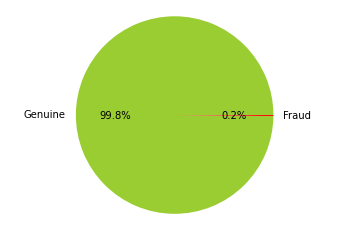

In [16]:
# Vẽ để xem tỉ lệ genuine/fraud
fig, ax = plt.subplots(1, 1)
ax.pie(df.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

Text(0, 0.5, '# transactions')

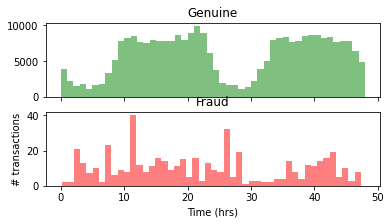

In [17]:
#Vẽ số genuine/fraud transcation theo Time để xem có trend nào không
df["Time_Hr"] = df["Time"]/3600 # convert to hours
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(6,3))
ax1.hist(df.Time_Hr[df.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(df.Time_Hr[df.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('# transactions')

- Không nhận thấy trend nào rõ ràng: bỏ qua cột `Time`

In [0]:
df = df.drop(['Time'],axis=1)

In [19]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time_Hr
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000278
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000278
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000556


Text(0, 0.5, '# transactions')

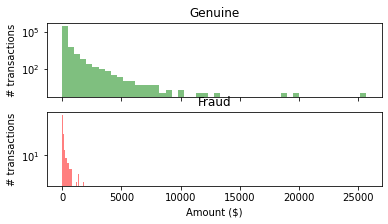

In [20]:
#Vẽ Amount cho Genuine/Fraud transactions
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (6,3), sharex = True)
ax3.hist(df.Amount[df.Class==0],bins=50,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Genuine') # to see the tails
ax3.set_ylabel('# transactions')
ax4.hist(df.Amount[df.Class==1],bins=50,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('# transactions')

In [21]:
df['Amount'].head()

0    149.62
1      2.69
2    378.66
3    123.50
4     69.99
Name: Amount, dtype: float64


- "all transaction amounts > 10K: Genuine Class only". 
- Trong các columns, `Amount` không cùng scale với giá trị các cột khác -> cần standardize giá trị cột `Amount`

In [0]:
#Chuẩn hóa dữ liệu cột Amount, thêm cột scaled_Amount
from sklearn.preprocessing import StandardScaler
df['scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))


In [0]:
#Xóa
df = df.drop(['Amount'],axis=1)

In [24]:
df['scaled_Amount'].head()

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
Name: scaled_Amount, dtype: float64

## 2) Chuẩn bị training data và test data

In [25]:
drop_list = []
df = df.drop(drop_list,axis=1)
print(df.columns)
#test train split time
from sklearn.model_selection import train_test_split
y = df['Class'].values #target
X = df.drop(['Class'],axis=1).values #features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                            random_state=42, stratify=y)

print("train-set size: ", len(y_train), "\ntest-set size: ", len(y_test))
print("fraud cases in test-set: ", sum(y_test))


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Time_Hr',
       'scaled_Amount'],
      dtype='object')
train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98


## 3) Xây dựng mô hình phân lớp GaussianNB

In [26]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
# fit it to training data
clf.fit(X_train,y_train)
clf

GaussianNB(priors=None, var_smoothing=1e-09)

In [27]:
# predict using test data
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [28]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test)
y_pred_prob

array([[1.00000000e+00, 1.94414845e-17],
       [1.00000000e+00, 2.33418489e-12],
       [3.81200558e-02, 9.61879944e-01],
       ...,
       [1.00000000e+00, 1.48169798e-17],
       [1.00000000e+00, 8.48836888e-18],
       [1.00000000e+00, 6.54925798e-16]])

In [29]:
train_pred = clf.predict(X_train)
train_pred

array([0, 0, 0, ..., 0, 0, 0])

## 4) Evaluation

#### Tập train

In [30]:
print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 

train-set confusion matrix:
 [[222480   4971]
 [    69    325]]


#### Tập test

In [31]:
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
print("recall score: ", recall_score(y_test,y_pred))


test-set confusion matrix:
 [[55535  1329]
 [   15    83]]
recall score:  0.8469387755102041


In [32]:
print("precision score: ", precision_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))


precision score:  0.058781869688385266
f1 score:  0.10993377483443707


In [33]:
print("accuracy score: ", accuracy_score(y_test,y_pred))


accuracy score:  0.9764053228468101


In [34]:
print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

ROC AUC: 0.963247971529636
